(demo2022-07-18)=
# Demo Notebook 2022-07-18

Demos from the live sessions on 2022-07-18.


## Setup



In [1]:
import grama as gr
import pandas as pd
import numpy as np
DF = gr.Intention()
%matplotlib inline


## Load the challenge data


In [2]:
df_data = pd.read_csv("../challenges/data/c05-data.csv")
df_data

,E,mu,t,id_machine,id_specimen,id_measurement
0,10113.457096,0.319442,0.250,A,0,g
1,9432.148720,0.308230,0.250,A,1,g
2,10468.172283,0.328422,0.250,A,2,g
3,9474.697920,0.333919,0.250,A,3,g
4,10010.402837,0.310751,0.250,A,4,g
...,...,...,...,...,...,...
715,11935.167126,0.319328,0.125,F,115,l
716,11552.946124,0.317546,0.125,F,116,l
717,11985.579932,0.332173,0.125,F,117,l
718,12092.949690,0.317655,0.125,F,118,l


## Compare across thicknesses

I chose to make this comparison using boxplots. These are a simple (and underrated!) way to make comparisons across groups.

A particularly helpful tip is to use `notch=True` with boxplots. This visualizes a confidence interval on the median (the middle line), which is helpful for assessing the statistical signifance of differences. As we can see from the boxplots below, the two notches are highly separated, suggesting that the difference is statistically significant (not likely to be due to chance alone).


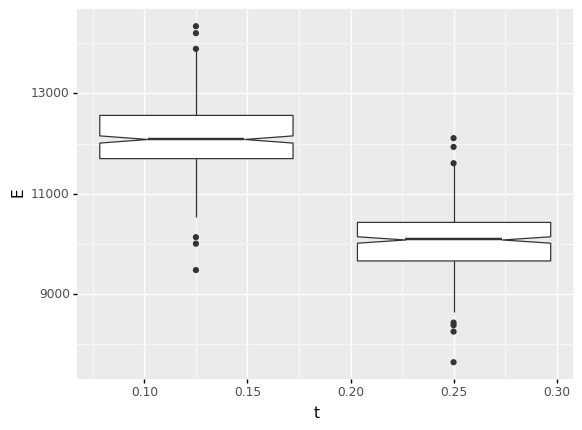

<ggplot: (8769249496507)>

In [3]:
## TODO: Compare elasticity across thicknesses
## NOTE: There are many ways to do this!
(
    df_data
# solution-begin
    >> gr.ggplot(gr.aes("t", "E"))
    + gr.geom_boxplot(gr.aes(group="t"), notch=True)
# solution-end
)

## Fitting a lognorm

First, let's set up the data as it was in the challenge. We seek to model the variability of `E` as observed in `df_sub`.


In [4]:
## NOTE: No need to edit
df_sub = (
    df_data
    >> gr.tf_filter(
        DF.t == 0.250,
        DF.id_machine != "C",
        DF.id_measurement != "h",
    )
)

The following code fits a lognormal distribution to the observations on `E`.

Note that the `"lognorm"` distribution in grama uses the [scipy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html). As noted in that documentation, the `loc` and `scale` parameters are used to modify the input variable `(x - loc) / scale`. However, we can *freeze* the location parameter of the distribution by setting `floc=0`. This is useful when fitting a lognormal distribution becomes unstable. The following code demonstrates this phenomenon:


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


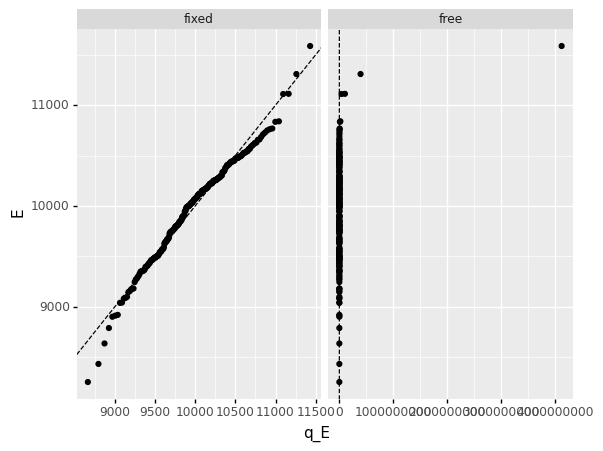

<ggplot: (8769300923706)>

In [5]:
## Fit with loc == 0
mg_fixed = gr.marg_fit(
    "lognorm", 
    df_sub.E, 
    floc=0,
)

## Fit with loc able to move
mg_free = gr.marg_fit(
    "lognorm", 
    df_sub.E, 
    # floc=0, # Don't set the location parameter to zero
)

## Use QQ plot to asses
(
    df_sub
    >> gr.tf_mutate(
        fixed=gr.qqvals(DF.E, marg=mg_fixed),
        free=gr.qqvals(DF.E, marg=mg_free),
    )
    >> gr.tf_pivot_longer(
        columns=["fixed", "free"],
        names_to="location",
        values_to="q_E",
    )
    
    >> gr.ggplot(gr.aes("q_E", "E"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
    + gr.facet_grid("~location", scales="free_x")
)

Clearly the `free` option has resulted in a terrible fit!

We can also see that the fitted parameter values for the `free` version have ended up being enormous (and implausible). 

In [6]:
print(mg_fixed)  # floc == 0 (fixed)
print(mg_free)   # floc free

(+0) lognorm, {'mean': '9.965e+03', 's.d.': '4.977e+02', 'COV': 0.05, 'skew.': 0.15, 'kurt.': 3.04}
(+0) lognorm, {'mean': '2.409e+13', 's.d.': '3.298e+26', 'COV': 13691416095072.72, 'skew.': 2.5665226910475562e+39, 'kurt.': 1.2347725193581465e+105}


## Real variability?

Note that the tails of the fitted distribution seem to exhibit some mismatch:


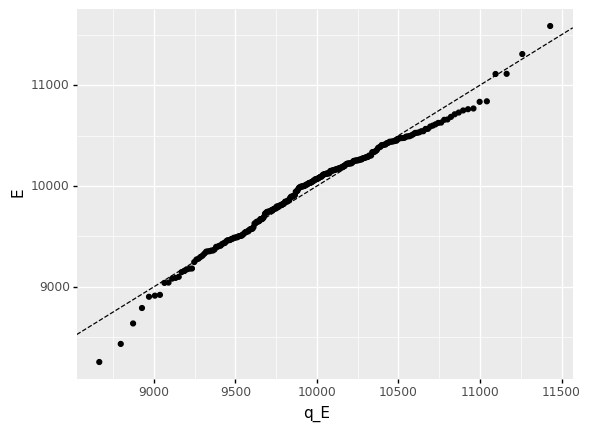

<ggplot: (8769300926805)>

In [7]:
(
    df_sub
    >> gr.tf_mutate(
        q_E=gr.qqvals(DF.E, marg=mg_fixed),
    )
    
    >> gr.ggplot(gr.aes("q_E", "E"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
)

This is a problem for us, as we're aiming to assess probabilities that lie in the tails (around the 1% level). 

Part of the issue here is that the real and erroneous variability mingle to create a complicated, non-standard distribution. We can improve the situation by applying the mean heuristic to the data:


In [8]:
## NOTE: No need to edit
df_real = (
    df_sub
    >> gr.tf_group_by(DF.id_specimen)
    >> gr.tf_summarize(
        mu=gr.mean(DF.mu),
        E=gr.mean(DF.E),
    )
    >> gr.tf_ungroup()
)

Now re-fit the marginal distribution on the reduced dataset:

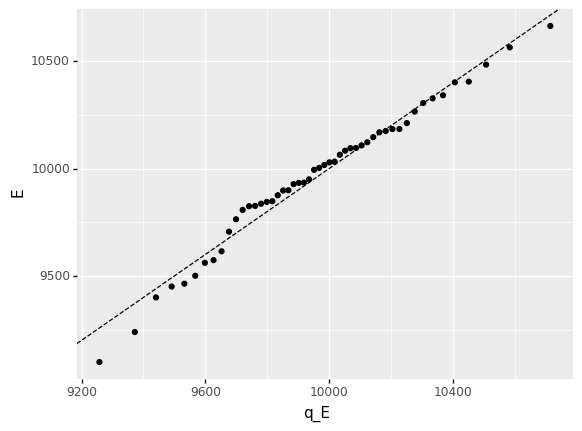

<ggplot: (8769288398324)>

In [9]:
# solution-begin
mg_E = gr.marg_fit(
    "lognorm", 
    df_real.E, 
    floc=0,
)

(
    df_real
    >> gr.tf_mutate(
        q_E=gr.qqvals(DF.E, marg=mg_E),
    )
    
    >> gr.ggplot(gr.aes("q_E", "E"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
)
# solution-end

As discussed in the morning session, this fit is still not perfect. However, we can see that the points generally lie closer to the line than before.

Since the real variability *actually* was generated from a lognormal distribution, the remaining mismatch here is due to erroneous (sampling) variability. Dealing with this remaining uncertainty is outside the scope of this course, but you can take a look at the Further Reading below for more information!


## Further reading

- [When are allowables conservative?](https://arc.aiaa.org/doi/full/10.2514/1.J059578)
  - Discusses basis values, which are used in aerospace engineering to account for both real and erroneous (sampling) sources of variability simultaneously.
  - Also discusses the limitations of allowable (single) values for engineering analysis purposes.
